# Import functions

In [86]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seed
np.random.seed(1)
torch.manual_seed(1)

# HJ PDE Experiment: 1D Quadratic term with L2 initial data  
$J(x) = \frac{\alpha}{2}\Vert x\Vert^{2}$.

# Parameters of the HJ PDE

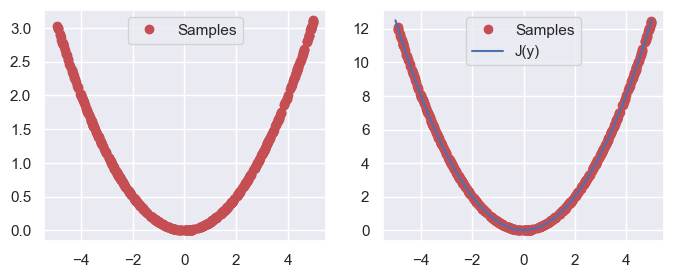

In [87]:
# We consider here the non-convex optimization problem:
# S(y) = min_{x \in \R} \frac{1}{2}(x-y)^{2} + J(x)
# where J(x) = 0.5 * \alpha * ||x||^2.

# This problem admits the explicit solution
# S(y) = 0.5*(y^{2}*alpha/(1+alpha)).

# The proximal operator is given by
# prox_{J}(y) = y/(1+y).

# We'll train a Learned Proximal Network to learn the solution
# of this problem from a set of K samples (yk,S(yk))_{k=1}^{K}.

# Parameters of the HJ PDE
alpha = 1

# Number of samples and range [a,b] from which to sample and plot
K = 500
b = 5
a = -5 


# True solution S(y,t)
def compute_true_solution(y,alpha):
    """
    Inputs:
        y:              ``Spatial" variable of the HJ solution
        alpha:          Regularization parameter

    Outputs:      
        Sy:             Solution to the minplus HJ PDE
    """

    Sy = 0.5*torch.pow(y*alpha/(1+alpha),2)
    return Sy


# Initial data J(y)
def compute_initial_data_minplus(y,alpha):
    """
    Inputs:
        y:              ``Spatial" variable of the HJ solution
        alpha:          Rgularization parameter

    Outputs:      
        Jy:             Value of the initial data of the minplus HJ PDE
    """

    Jy = 0.5*alpha*torch.pow(y,2)
    return Jy

    
# Generate K samples uniformly from [-3,5]
ysamples = a + (b-a)*torch.rand(size=(K,1)) 
Sysamples = compute_true_solution(ysamples,alpha)
Jysamples = compute_initial_data_minplus(ysamples,alpha)

# Compute the true solution S(y)
ytrue = np.linspace(a,b,25)
Sytrue = 0.5*pow(ytrue*alpha/(1+alpha),2)
Jytrue = 0.5*alpha*pow(ytrue,2)

plt.subplot(1,2,1)
plt.plot(ysamples.numpy(),Sysamples.numpy(),'o', color='r',label="Samples");
plt.legend()

plt.subplot(1,2,2)
plt.plot(ysamples.numpy(),Jysamples.numpy(),'o', color='r', label="Samples")
plt.plot(ytrue,Jytrue,'-',label="J(y)")
plt.legend()


# Model parameters

In [88]:
# Default values
# beta = 10       # beta of softplus
# hidden = 50     # number of hidden units
# layers = 4      # number of layers

beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers

# Create a model
lpn_model = LPN(in_dim = 1, hidden=hidden, layers=layers, beta=beta).to(device)

print(
    "Number of parameters in ICNN",
    sum(p.size().numel() for p in lpn_model.parameters()),
)

Number of parameters in ICNN 10502


# Plot function

In [89]:
# Plotting an LPN model
# function to plot learned prox, convex function, original function
def plot_all(model,ysamples,Sysamples,Jysamples,alpha):
    xi = np.linspace(a, b, 300)

    # Compute the learned proximal opertor and convex function.
    prox_y = prox(xi, model)
    c = cvx(xi, model)

    ysamples = ysamples.detach().numpy()
    Sysamples = Sysamples.detach().numpy()
    Jysamples = Jysamples.detach().numpy()

    plt.rcParams["figure.figsize"] = (8, 3)

    # Learned proximal operator
    prox_true = xi/(1+alpha)

    plt.subplot(1, 2, 1)
    plt.plot(xi, prox_y, "--", ms=5, label="LPN")
    plt.plot(xi, prox_true,".", label="True proximal")
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # Convex function
    # Note: The convex function is equal to 0.5*y^2 - S(y,t)
    plt.subplot(1, 2, 2)
    plt.plot(xi, c - c.min(), "--", ms=5, label="Cvx func -- LPN")
    plt.plot(ysamples, 0.5*pow(ysamples,2) - Sysamples, ".", label="Cvx func at samples -- True")
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # # Initial data J(y) evaluate
    # Jyprox = 0.5*np.minimum(pow(prox_y-mu1,2)/sigma1,pow(prox_y-mu2,2)/sigma2)

    # plt.subplot(1, 3, 3)
    # plt.plot(xi,Jyprox,"--", label="Estimated initial data J(y)")
    # plt.plot(ysamples, Jysamples,".", label="True Initial data J(y) at the samples")
    # plt.grid("on")
    # plt.legend()
    # plt.title("Initial data")

    plt.tight_layout()

# Proximal matching loss

In [90]:
# Proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1

# Training function

In [91]:
# Defines what is a single iteration in the training of the LPN.xw

def single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss=None):
    input = ysamples
    out = lpn_model(input)

    target = 0.5*(torch.pow(ysamples,2)) - compute_true_solution(ysamples,alpha)
    fout = 0.5*(torch.pow(out,2)) - compute_true_solution(out,alpha)

    if loss_type == 2:
        loss = (fout - target).pow(2).sum() / K  # MSE loss
    elif loss_type == 1:
        loss = (fout - target).abs().sum() / K  # MAE loss
    elif loss_type == 0:
        loss = exp_func(fout - target, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    if not i % 500:
        print("iteration", i, "loss", loss.item())

# Train

L2 loss

iteration 0 loss 11.992332458496094
iteration 500 loss 1.5139423608779907
iteration 1000 loss 0.378804087638855
iteration 1500 loss 0.06594337522983551
iteration 2000 loss 0.009796672500669956
iteration 2500 loss 0.00233220006339252
iteration 3000 loss 0.000905702356249094
iteration 3500 loss 0.0004968878929503262
iteration 4000 loss 0.0003139167092740536
iteration 4500 loss 0.0002150336658814922
iteration 5000 loss 0.00015719803923275322
iteration 5500 loss 0.00011841085506603122
iteration 6000 loss 8.85692352312617e-05
iteration 6500 loss 6.634274905081838e-05
iteration 7000 loss 5.023091216571629e-05
iteration 7500 loss 3.834564995486289e-05
iteration 8000 loss 3.0564857297576964e-05
iteration 8500 loss 2.5206105419783853e-05
iteration 9000 loss 2.0887102436972782e-05
iteration 9500 loss 1.834413706092164e-05
iteration 0 loss 1.6314146705553867e-05
iteration 500 loss 1.6091473298729397e-05
iteration 1000 loss 1.581421929586213e-05
iteration 1500 loss 1.5470719517907128e-05
iteration

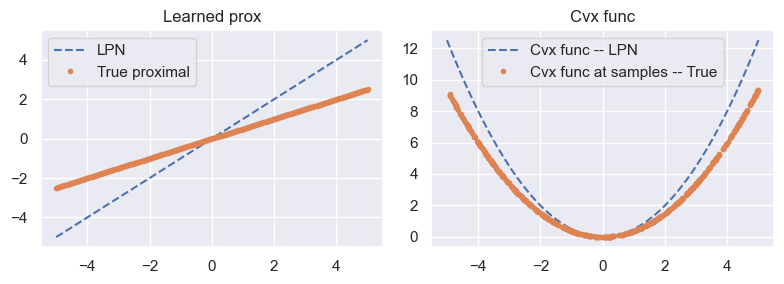

In [92]:
# Initialize
lpn_model = LPN(in_dim=1, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-4)
loss_type = 2


# Train for 10000 iterations
for i in range(10000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(10000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model,ysamples,Sysamples,Jysamples,alpha)
# print(
#     "Values at [-3,-2,-1,0,1,2,3]:",
#     lpn_model(
#         torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
#     ).squeeze(1),
# )


L1 loss

iteration 0 loss 2.7014169692993164
iteration 500 loss 0.037168096750974655
iteration 1000 loss 0.0612025186419487
iteration 1500 loss 0.029152367264032364
iteration 2000 loss 0.08145451545715332
iteration 2500 loss 0.08197558671236038
iteration 3000 loss 0.05454113706946373
iteration 3500 loss 0.07152136415243149
iteration 4000 loss 0.07235994935035706
iteration 4500 loss 0.04392649978399277
iteration 5000 loss 0.028110787272453308
iteration 5500 loss 0.04026613011956215
iteration 6000 loss 0.025134164839982986
iteration 6500 loss 0.024941476061940193
iteration 7000 loss 0.01848098449409008
iteration 7500 loss 0.11048470437526703
iteration 8000 loss 0.05261926352977753
iteration 8500 loss 0.037791624665260315
iteration 9000 loss 0.020731844007968903
iteration 9500 loss 0.018480094149708748
iteration 0 loss 0.028382595628499985
iteration 500 loss 0.0018713853787630796
iteration 1000 loss 0.0016613974003121257
iteration 1500 loss 0.0014869574224576354
iteration 2000 loss 0.0013254075311

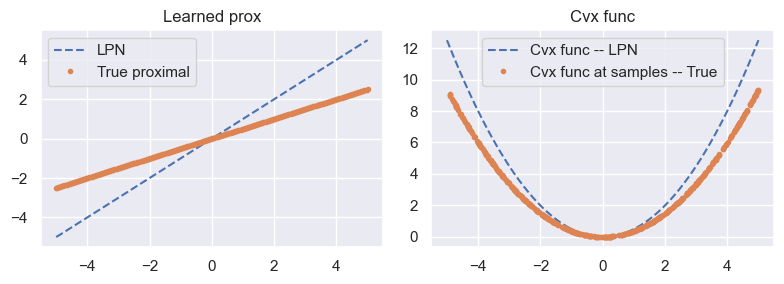

In [93]:
# Initialize
lpn_model = LPN(in_dim=1, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
loss_type = 1

# Train for 10000 iterations
for i in range(10000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(10000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type)

# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model,ysamples,Sysamples,Jysamples,alpha)

Proximal matching loss with gamma = 0.1

iteration 0 loss 0.0003583182115107775
iteration 500 loss 0.0001437422033632174
iteration 1000 loss 0.00011635005648713559
iteration 1500 loss 9.624958329368383e-05
iteration 2000 loss 8.026159048313275e-05
iteration 2500 loss 7.038498006295413e-05
iteration 3000 loss 6.424701132345945e-05
iteration 3500 loss 0.00035589528852142394
iteration 4000 loss 5.509078619070351e-05
iteration 4500 loss 5.131721627549268e-05
iteration 0 loss 4.837596497964114e-05
iteration 500 loss 4.811727922060527e-05
iteration 1000 loss 4.778885704581626e-05
iteration 1500 loss 4.735768015962094e-05
iteration 2000 loss 4.6788452891632915e-05
iteration 2500 loss 4.609465759131126e-05
iteration 3000 loss 4.521119626588188e-05
iteration 3500 loss 4.411184636410326e-05
iteration 4000 loss 4.280650682630949e-05
iteration 4500 loss 4.1224957385566086e-05


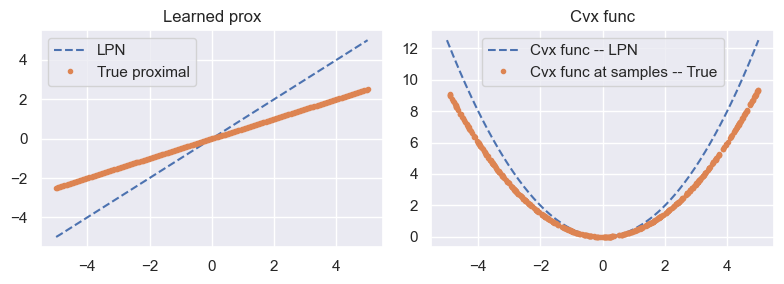

In [94]:
loss_type = 0
gamma_loss = 0.1

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(5000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(5000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model,ysamples,Sysamples,Jysamples,alpha)

Proximal matching with gamma = 0.01

In [95]:
loss_type = 0
gamma_loss = 0.01

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(5000):
    single_iteration(i, ysamples, Sysamples, K, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model,ysamples,Sysamples,Jysamples,alpha)

iteration 0 loss 0.0038606461603194475
iteration 500 loss 0.003728365059942007
iteration 1000 loss 0.004330950323492289
iteration 1500 loss 0.004280381370335817
iteration 2000 loss 0.004122317302972078
iteration 2500 loss 0.004260227084159851
iteration 3000 loss 0.0041662538424134254
iteration 3500 loss 0.00407587131485343
iteration 0 loss 0.003857412375509739
iteration 500 loss 0.002740987576544285
iteration 1000 loss 0.0027276435866951942
iteration 1500 loss 0.0027118739672005177
iteration 2000 loss 0.0026903958059847355
iteration 2500 loss 0.002662699669599533
iteration 3000 loss 0.002629281487315893
iteration 3500 loss 0.0025853440165519714
iteration 4000 loss 0.0025302348658442497
iteration 4500 loss 0.002463830402120948


KeyboardInterrupt: 